## Adapted from Victor Zhou's CNN published at [this blog post](https://victorzhou.com/blog/keras-cnn-tutorial/).

In [1]:
import math
import mnist
import numpy as np
import time

# Using tf.keras for Ghost Batch Norm capability.
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Nadam

import tensorflow as tf
#print(tf.version)
# Disable INFO and WARNING messages from TensorFlow.
# Our Keras version (2.2.4 / TF 1.15.0) throws deprecation warnings.
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
train_images = mnist.train_images() 
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

In [3]:
# Build the model.
batch_size = 100       # TODO: make this less arbitrary.
ghost_batch_size = 10  # TODO: make this less arbitrary.

model = Sequential([
    # The authors required ghost batch normalization in their experiments.
    # The papers they reference use normalization preceding each convolutional layer.
    BatchNormalization(virtual_batch_size=ghost_batch_size),
    Conv2D(filters=num_filters, kernel_size=filter_size, input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [4]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.time = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.time += time.time() - self.epoch_time_start

In [5]:
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay(epoch):
    # This starts with a learning rate higher than the default learning rate in
    # Vanilla SGD. It drops by a factor of 5 each step, and I chose to drop after
    # every other epoch to make training not take too long on a laptop.
    # Think of this as a half-life equation.
    initial_lrate=0.15
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

In [6]:
# Compile the model.
epochs = 6            # Run enough epochs to test the training schedule.
learning_rate = 0.00  # Will be overrided by the scheduler.
decay_rate = 0.00     # Default decay rate.
momentum = 0.0        # Default momentum.

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## Experiment 1: Vanilla SGD, decaying learning rate.

In [7]:
# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)
time_callback = TimeHistory()

exp1_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler, time_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2627 - acc: 0.9215 - val_loss: 0.1237 - val_acc: 0.9608
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 98us/sample - loss: 0.1249 - acc: 0.9623 - val_loss: 0.0934 - val_acc: 0.9707
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0767 - acc: 0.9778 - val_loss: 0.0792 - val_acc: 0.9749
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0696 - acc: 0.9797 - val_loss: 0.0779 - val_acc: 0.9750
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 98us/sample - loss: 0.0621 - acc: 0.9819 - val_loss: 0.0751 - val_acc: 0.9768
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 97us/sam

In [8]:
print(exp1_results.history)
print("")
print(time_callback.time)
times = []
times.append(time_callback.time)

{'loss': [0.2626516235154122, 0.12486908462519447, 0.07670254747848958, 0.06959664875719075, 0.062060326189578824, 0.061309692052503424], 'acc': [0.92155, 0.9622667, 0.97783333, 0.97975, 0.98193336, 0.98191667], 'val_loss': [0.12371403381228446, 0.09342036141082645, 0.0792184588778764, 0.07794096438214183, 0.07513288855552673, 0.0750067605637014], 'val_acc': [0.9608, 0.9707, 0.9749, 0.975, 0.9768, 0.9766], 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

35.15199947357178


## Experiment 2: Vanilla SGD, increasing batch size.

In [9]:
# Keras has no built in for this. 
# Code is from https://www.codementor.io/nitinsurya/how-to-re-initialize-keras-model-weights-et41zre2g
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [10]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp2_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time
print(time_tmp)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time
print(time_tmp)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time
print(time_tmp)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2917 - acc: 0.9137 - val_loss: 0.1402 - val_acc: 0.9587
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1293 - acc: 0.9627 - val_loss: 0.1065 - val_acc: 0.9676
12.018999814987183
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0877 - acc: 0.9751 - val_loss: 0.0885 - val_acc: 0.9721
Epoch 2/2
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0809 - acc: 0.9766 - val_loss: 0.0837 - val_acc: 0.9732
23.168999671936035
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0735 - acc: 0.9792 - val_loss: 0.0816 - val_acc: 0.9743
Epoch 2/2
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0721 - acc: 0.9797 - val_loss: 0.0810 -

In [11]:
print(exp2_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.2916669948771596, 0.1292655826266855, 0.08771094412853321, 0.08093718315164249, 0.0735211259064575, 0.07205248313645522], 'acc': [0.91366667, 0.9626833, 0.97508335, 0.97665, 0.9792167, 0.97975], 'val_loss': [0.1402483084052801, 0.10653930706903339, 0.08846086170524359, 0.08368968516588211, 0.08158365450799465, 0.08095896244049072], 'val_acc': [0.9587, 0.9676, 0.9721, 0.9732, 0.9743, 0.9744]}
[35.15199947357178, 33.190999269485474]


## Experiment 3: Vanilla SGD, hybrid.

In [12]:
def hybrid_lr_decay(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.05
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler = LearningRateScheduler(hybrid_lr_decay)

In [13]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp3_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler, time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp3_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2613 - acc: 0.9234 - val_loss: 0.1329 - val_acc: 0.9615
Epoch 2/2
60000/60000 [==============================] - 6s 100us/sample - loss: 0.1227 - acc: 0.9633 - val_loss: 0.1038 - val_acc: 0.9685
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0843 - acc: 0.9756 - val_loss: 0.0839 - val_acc: 0.9745
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0781 - acc: 0.9773 - val_loss: 0.0803 - val_acc: 0.9758
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0716 - acc: 0.9796 - val_loss: 0.0790 - val_acc: 0.9762
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 6s 93us/sample - loss: 

In [14]:
print(exp3_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.26127125553165875, 0.1226835576320688, 0.08428708047916492, 0.07808773337552945, 0.0715997357542316, 0.07014655467743675], 'acc': [0.9234, 0.9633333, 0.9755833, 0.9773333, 0.97961664, 0.97996664], 'val_loss': [0.1329448164999485, 0.10383092621341347, 0.08387802243232727, 0.08029752373695373, 0.07898560650646687, 0.07836616709828377], 'val_acc': [0.9615, 0.9685, 0.9745, 0.9758, 0.9762, 0.9759]}
[35.15199947357178, 33.190999269485474, 34.424999475479126]


## Experiment 4: Adam, decaying learning rate

In [15]:
'''
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay_adam(epoch):
    # Same learning-rate decaying algorithm as Vanilla SGD, except setting the initial rate to 0.001
    initial_lrate=0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate
'''
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp4_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler, time_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 105us/sample - loss: 1.5461 - acc: 0.9139 - val_loss: 0.1346 - val_acc: 0.9604
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.1380 - acc: 0.9595 - val_loss: 0.1180 - val_acc: 0.9633
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0816 - acc: 0.9760 - val_loss: 0.0894 - val_acc: 0.9723
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0736 - acc: 0.9776 - val_loss: 0.0850 - val_acc: 0.9742
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0572 - acc: 0.9830 - val_loss: 0.0790 - val_acc: 0.9765
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 102

In [16]:
print(exp4_results.history)
times.append(time_callback.time)
print(times)

{'loss': [1.5460891580892107, 0.137986951743563, 0.08163573156576603, 0.07361573048712065, 0.05721136961520339, 0.0547628556843847], 'acc': [0.91386664, 0.9594833, 0.97601664, 0.97763336, 0.98301667, 0.9837833], 'val_loss': [0.13464369904249907, 0.11796167701482772, 0.08939796333201229, 0.08498491549864412, 0.0790168394614011, 0.0802736328355968], 'val_acc': [0.9604, 0.9633, 0.9723, 0.9742, 0.9765, 0.976], 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194]


## Experiment 5: Adam, increasing batch size.

In [17]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp5_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4911 - acc: 0.8644 - val_loss: 0.2520 - val_acc: 0.9291
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2230 - acc: 0.9356 - val_loss: 0.1796 - val_acc: 0.9502
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1701 - acc: 0.9528 - val_loss: 0.1645 - val_acc: 0.9520
Epoch 2/2
60000/60000 [==============================] - 6s 94us/sample - loss: 0.1589 - acc: 0.9560 - val_loss: 0.1527 - val_acc: 0.9556
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 84us/sample - loss: 0.1495 - acc: 0.9587 - val_loss: 0.1505 - val_acc: 0.9563
Epoch 2/2
60000/60000 [==============================] - 5s 84us/sample - loss: 0.1476 - acc: 0.9588 - val_loss: 0.1490 - val_acc: 0.9569


In [18]:
print(exp5_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.4910899055997531, 0.22297070593262713, 0.17013441920280456, 0.15888296980410815, 0.14949942473322153, 0.14759662002325058], 'acc': [0.8644, 0.93558335, 0.95281667, 0.95601666, 0.9587167, 0.95875], 'val_loss': [0.2520021337270737, 0.17961593367159367, 0.1645421724766493, 0.15270891599357128, 0.15048576891422272, 0.1490233950316906], 'val_acc': [0.9291, 0.9502, 0.952, 0.9556, 0.9563, 0.9569]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194, 33.8219997882843]


## Experiment 6: Adam, hybrid.

In [19]:
def hybrid_lr_decay_adam(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.001 #initial learning rate for Adam's Keras's default = 0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler_adam = LearningRateScheduler(hybrid_lr_decay_adam)

In [20]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp6_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler_adam, time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp6_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4227 - acc: 0.8816 - val_loss: 0.2209 - val_acc: 0.9368
Epoch 2/2
60000/60000 [==============================] - 6s 100us/sample - loss: 0.1961 - acc: 0.9441 - val_loss: 0.1626 - val_acc: 0.9535
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.001000
Epoch 1/4
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1461 - acc: 0.9588 - val_loss: 0.1492 - val_acc: 0.9576
Epoch 2 learning rate: 0.001000
Epoch 2/4
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1355 - acc: 0.9627 - val_loss: 0.1397 - val_acc: 0.9604
Epoch 3 learning rate: 0.000200
Epoch 3/4
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1265 - acc: 0.9644 - val_loss: 0.1365 - val_acc: 0.9616
Epoch 4 learning rate: 0.000200
Epoch 4/4
60000/60000 [==============================] - 6s 92us/sample - loss: 

In [21]:
print(exp6_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.4227435835202535, 0.1960861801231901, 0.14613503515720366, 0.13546914253383874, 0.1265472526351611, 0.123703837270538], 'acc': [0.88155, 0.94413334, 0.9588, 0.9626667, 0.9644, 0.96603334], 'val_loss': [0.22089868545532226, 0.162645605802536, 0.1491612307727337, 0.13969728760421277, 0.13652907609939574, 0.13458913564682007], 'val_acc': [0.9368, 0.9535, 0.9576, 0.9604, 0.9616, 0.9619]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194, 33.8219997882843, 34.14800000190735]


## Experiment 7: SGD with momentum, decaying learning rate.

In [22]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp7_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler, time_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 99us/sample - loss: nan - acc: 0.0999 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 98us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 98us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 98us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 99us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 97us/sample - loss: nan - acc: 0.0987 

In [23]:
print(exp7_results.history)
times.append(time_callback.time)
print(times)

{'loss': [nan, nan, nan, nan, nan, nan], 'acc': [0.09991667, 0.09871667, 0.09871667, 0.09871667, 0.09871667, 0.09871667], 'val_loss': [nan, nan, nan, nan, nan, nan], 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098], 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194, 33.8219997882843, 34.14800000190735, 35.31700015068054]


## Experiment 8: SGD with momentum, increasing batch size.

In [24]:
reset_weights(model)
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp8_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 101us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 98us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 91us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 5s 91us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 80us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 5s 80us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980


In [25]:
print(exp8_results.history)
times.append(time_tmp)
print(times)

{'loss': [nan, nan, nan, nan, nan, nan], 'acc': [0.09871667, 0.09871667, 0.09871667, 0.09871667, 0.09871667, 0.09871667], 'val_loss': [nan, nan, nan, nan, nan, nan], 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194, 33.8219997882843, 34.14800000190735, 35.31700015068054, 32.45899987220764]


## Experiment 9: SGD with momentum, hybrid.

In [26]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp9_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler, time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp9_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 100us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 6s 92us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 5s 91us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 5s 90us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 5s 90us/sample - loss: nan - acc: 0.0987 - val_loss: n

In [27]:
print(exp9_results.history)
times.append(time_tmp)
print(times)

{'loss': [nan, nan, nan, nan, nan, nan], 'acc': [0.09871667, 0.09871667, 0.09871667, 0.09871667, 0.09871667, 0.09871667], 'val_loss': [nan, nan, nan, nan, nan, nan], 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}
[35.15199947357178, 33.190999269485474, 34.424999475479126, 36.926000356674194, 33.8219997882843, 34.14800000190735, 35.31700015068054, 32.45899987220764, 33.70599937438965]


## Experiment 1-3 Plots

In [28]:
import matplotlib
import matplotlib.pyplot as plt

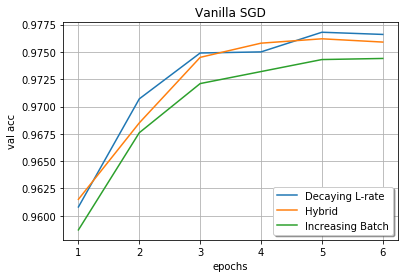

In [29]:
f_vanillasgd, a_vanillasgd = plt.subplots()
a_vanillasgd.plot(range(1,7), exp1_results.history["val_acc"], label="Decaying L-rate")
a_vanillasgd.plot(range(1,7), exp3_results.history["val_acc"], label="Hybrid")
a_vanillasgd.plot(range(1,7), exp2_results.history["val_acc"], label="Increasing Batch")

legend = a_vanillasgd.legend(loc='lower right', shadow=True, fontsize='medium')
a_vanillasgd.set(xlabel='epochs', ylabel='val acc', title='Vanilla SGD')
a_vanillasgd.grid()

f_vanillasgd.savefig("vanilla_sgd.png")

## Experiment 4-6 Plots

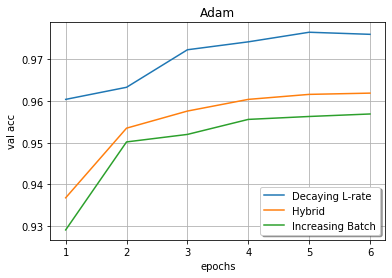

In [30]:
f_adam, a_adam = plt.subplots()
a_adam.plot(range(1,7), exp4_results.history["val_acc"], label="Decaying L-rate")
a_adam.plot(range(1,7), exp6_results.history["val_acc"], label="Hybrid")
a_adam.plot(range(1,7), exp5_results.history["val_acc"], label="Increasing Batch")

legend = a_adam.legend(loc='lower right', shadow=True, fontsize='medium')
a_adam.set(xlabel='epochs', ylabel='val acc', title='Adam')
a_adam.grid()

f_adam.savefig("adam.png")

## Experiment 7-9 Plots

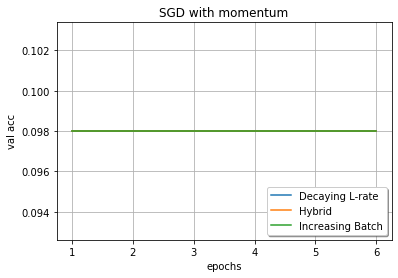

In [31]:
f_sgdm, a_sgdm = plt.subplots()
a_sgdm.plot(range(1,7), exp7_results.history["val_acc"], label="Decaying L-rate")
a_sgdm.plot(range(1,7), exp9_results.history["val_acc"], label="Hybrid")
a_sgdm.plot(range(1,7), exp8_results.history["val_acc"], label="Increasing Batch")

legend = a_sgdm.legend(loc='lower right', shadow=True, fontsize='medium')
a_sgdm.set(xlabel='epochs', ylabel='val acc', title='SGD with momentum')
a_sgdm.grid()

f_sgdm.savefig("sgd_with_momentum.png")

## Time comparison (1-3)

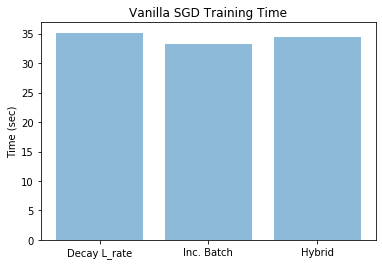

In [32]:
objects = ('Decay L_rate', 'Inc. Batch', 'Hybrid')
y_pos = np.arange(len(objects))
performance = times[0:3]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (sec)')
plt.title('Vanilla SGD Training Time')

plt.show()
#plt.savefig("vanillaSGD_time.png")

## Time comparison (4-6)

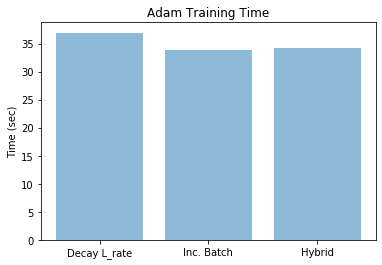

In [33]:
objects = ('Decay L_rate', 'Inc. Batch', 'Hybrid')
y_pos = np.arange(len(objects))
performance = times[3:6]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (sec)')
plt.title('Adam Training Time')

plt.show()

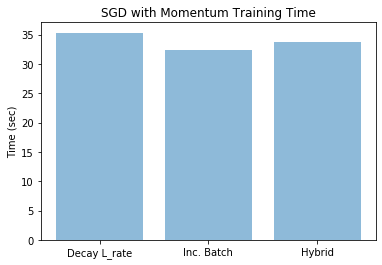

In [34]:
objects = ('Decay L_rate', 'Inc. Batch', 'Hybrid')
y_pos = np.arange(len(objects))
performance = times[6:9]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (sec)')
plt.title('SGD with Momentum Training Time')

plt.show()